# Capstone Project: The Battle of the Neighborhoods

## Table of contents
* [Introduction: Business Problem](#introduction)
    * [Background](#background)
    * [Business Problem](#business)
* [Data description](#data)
* [Analysis, Results and Discussion](#analysis)
    * [Home Values](#homevalue)
    * [Popular attraction using FourSquare API](#foursquare)
    * [Walk and Bike score](#walkscore)
* [Acknowlegment](#thanks)

## Introduction<a name="introduction"></a>
#### Background <a name="background"></a>

This project focuses on finding the concentration of residential area the cluster of  in the **Seattle Metropolis.** The population of Seattle is growing rapidly, and most of the concentration have expanded to new neighborhoods outside of the Seattle area. Here we will estimate average housing price in each neighborhood and also local attraction so that customer can make choice with their housing locations in the metro area. The aim will be create clusters of the most popular attractions and the cost of housing various neighborhoods.

#### Business Problem <a name="business"></a>

In this project, we will try to find an optimal location for a housing complex, and a location where might benefit the public and determine the rental. 

There are several existing neighborhoods in the Seattle Metropolis, but the new population is moving away from the Seattle city center. The population is moving towards the east in cities like Bellevue, Redmond, Issaquah and toward south Seattle neighborhood between Seatac and Puyallup. 

The project, in this initial stage, will use machine learning tools to identify various local attractions and housing prices for each neighborhood.

### Data Description<a name='data'></a>

For the project, I will need to collect 

1. Information on different neighborhood/zip code in the Seattle using **Google gecoding API**
2. Top ten local attractions must be listed for each neighborhood using **FourSquare API**
3. The housing cost (rent and ownership) information is colleted from various websites and services

Using the location, and local attraction and the cost of housing, a customer could decide which area they would prefer to reside on in the Metropolis.


### Analysis, Results and Discussion <a name="analysis"></a>
First step will be to import the required libraries to initiate the data retrival and processing. Some libraries may be imported later on as required basis.

In [167]:
import requests
import csv
import geocoder

In [60]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

from geopy.geocoders import Nominatim
from geopy.distance import vincenty

geolocator = Nominatim()


print('Libraries imported.')

Libraries imported.


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: DeprecationWarning: Using Nominatim with the default "geopy/1.21.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.


#### Home Value <a name="homevalue"> </a>
A comphrensive list of the seattle metropolis neighbhorhood data is available in the Zillow.com website. The data was available freely for data analysis and study. The dataset in present state only considers the home values and not the rental property. Below a csv file has been read for the home value data 

In [35]:
df = pd.read_csv('seattleNeighborhood.csv')
print('Total number of neighborhood in Seattle metropolis is:', df.shape[0])
df.set_index('Neighborhood', inplace = True)
df.head()

Total number of neighborhood in Seattle metropolis is: 310


,Neighborhood,State,City,County Name,Latitude,Longitude
0,Lea Hill,WA,Auburn,King County,47.325909,-122.180028
1,Meydenbauer,WA,Bellevue,King County,47.609155,-122.206071
2,Enatai,WA,Bellevue,King County,47.587412,-122.197571
3,Bellevue Downtown,WA,Bellevue,King County,47.615241,-122.192841
4,Newport Shores,WA,Bellevue,King County,47.570655,-122.192345


In [36]:
df.dtypes

Neighborhood     object
State            object
City             object
County Name      object
Latitude        float64
Longitude       float64
dtype: object

The geolocator in the previous processing step has not been able to identify the coordinates for all neighborhoods. Lets check how many neighborhoods does not have a latitude and longitdue information.

In [37]:
print('No Latitude', df["Latitude"].isna().sum())
print('No Longitude', df["Longitude"].isna().sum())

No Latitude 29
No Longitude 29


About 10% of the listed neighborhood does not have geolocation information. The neighborhood information in Zillow is very extensive and many not be quite necessary for our analysis. Lets drop and plot the remaining neighborhood in a geographical map.

In [38]:
df = df.dropna()

In [39]:
address = 'Seattle, WA'
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Seattle are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Seattle are 47.6038321, -122.3300624.


In [96]:
map_seattle = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, label in zip(df['Latitude'], df['Longitude'], df.index):
    label = folium.Popup(label, parse_html=True)
    folium.RegularPolygonMarker(
       [lat, lng],
        number_of_sides=40,
        radius=7,
        popup=label,
        color='#91nf09',
        fill_color= 'green',
        fill_opacity=0.9,).add_to(map_seattle)  
    
map_seattle

Get the home value data from 2016-2020

In [50]:
df2 = pd.read_csv('Seattle_HomeValues.csv')
df2 = df2.set_index('Neighborhoods')
df2.head()

,2016,2017,2018,2019,2020
Neighborhoods,,,,,
Capitol Hill,609596,706944,756442,731359,710619
University District,708421,826045,879534,850132,835157
Twin Lakes,326111,369863,386781,401374,418819
Magnolia,866531,978532,1043848,1012305,1027236
Greenwood,600515,703211,748983,729357,719925


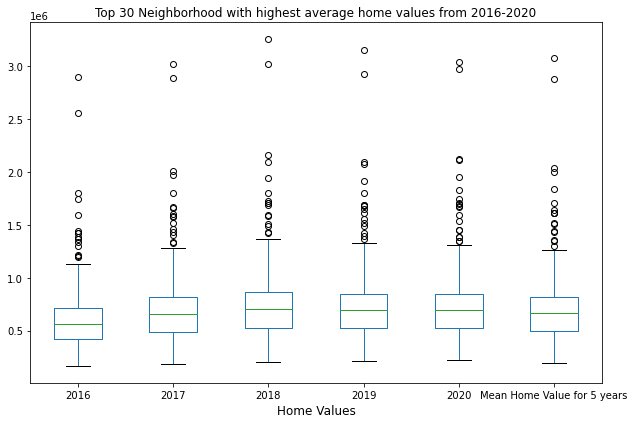

In [330]:
df2.plot(kind='box', figsize=(9, 6))
plt.xlabel('Home Values')
plt.title('Top 30 Neighborhood with highest average home values from 2016-2020')
plt.tight_layout()
plt.savefig('home_for_5years.pdf', pad_inches=0)

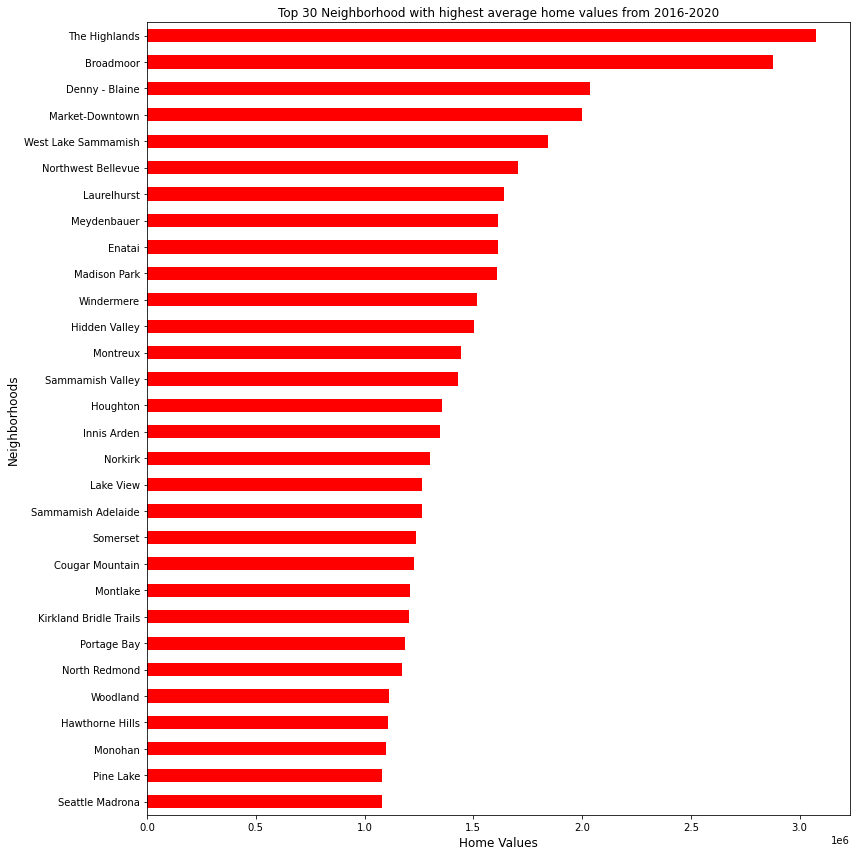

In [331]:
df2['Mean Home Value for 5 years'] = df2.mean(axis=1)
#df2 = df2.drop(columns='Average')
df_top15 = df2.sort_values('Mean Home Value for 5 years', axis = 0, ascending = True)
df_top15 = df_top15['Mean Home Value for 5 years'].tail(30)
df_top15.plot(kind='barh', figsize=(12, 12), color='red')
plt.xlabel('Home Values')
plt.title('Top 30 Neighborhood with highest average home values from 2016-2020')
plt.tight_layout()
plt.savefig('tophome.pdf', pad_inches=0)

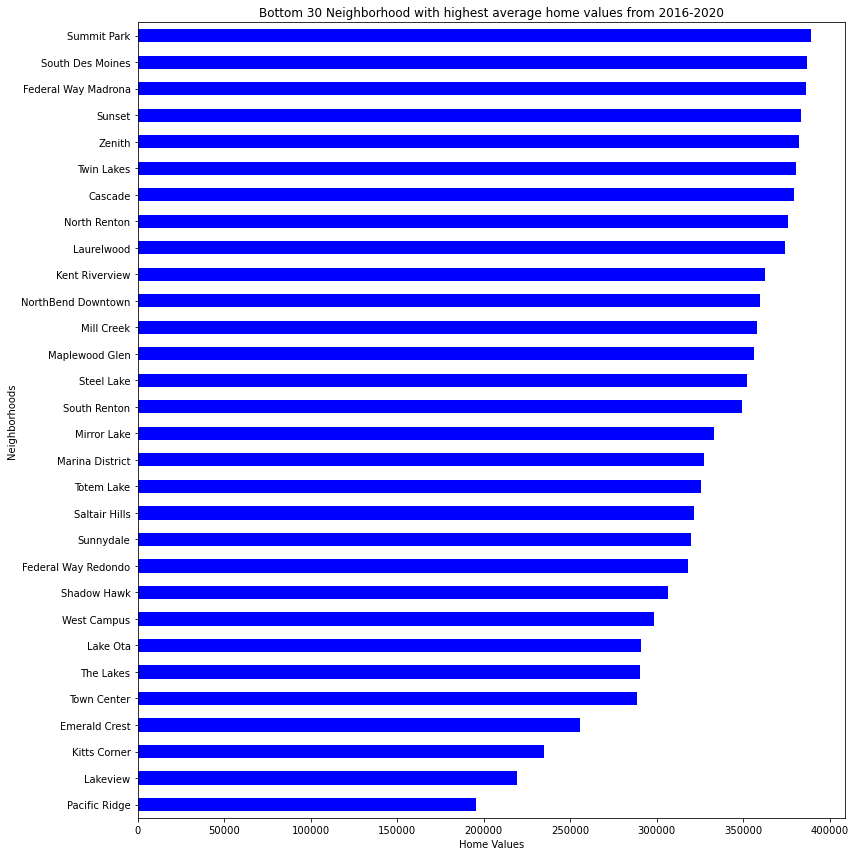

In [121]:
df_low15 = df2.sort_values('Mean Home Value for 5 years', axis = 0, ascending = True)
df_low15 = df_low15['Mean Home Value for 5 years'].head(30)
df_low15.plot(kind='barh', figsize=(12, 12), color='blue')
plt.xlabel('Home Values')
plt.title('Bottom 30 Neighborhood with highest average home values from 2016-2020')
plt.rc('axes', labelsize=12)
plt.tight_layout()
plt.savefig('bottomHome.pdf',pad_inches=0)

In [324]:
df_latlong = df[['Latitude', 'Longitude']]

In [106]:
df_15neigh = df_latlong.join(df_top15)
df_15neigh = df_15neigh.dropna()

In [325]:
df_low15neigh = df_latlong.join(df_low15)
df_low15neigh =df_low15neigh.dropna()

In [107]:
for lat, lng, label in zip(df_15neigh['Latitude'], df_15neigh['Longitude'], df_15neigh.index):
    label = folium.Popup(label, parse_html=True)
    folium.RegularPolygonMarker(
       [lat, lng],
        number_of_sides=40,
        radius=5,
        popup=label,
        color='#91nf09',
        fill_color= 'red',
        fill_opacity=0.9,).add_to(map_seattle) 
    
for lat, lng, label in zip(df_low15neigh['Latitude'], df_low15neigh['Longitude'], df_low15neigh.index):
    label = folium.Popup(label, parse_html=True)
    folium.RegularPolygonMarker(
       [lat, lng],
        number_of_sides=40,
        radius=5,
        popup=label,
        color='#91nf09',
        fill_color= 'blue',
        fill_opacity=0.9,).add_to(map_seattle) 
    
map_seattle

####  Popular attraction using FourSquare API <a name="foursquare"> </a>

In [302]:
df_neighborhood = df.join(df2)

In [303]:
df_neighborhood.dtypes
df_neighborhood.head()

,State,City,County Name,Latitude,Longitude,2016,2017,2018,2019,2020,Mean Home Value for 5 years
Neighborhood,,,,,,,,,,,
Lea Hill,WA,Auburn,King County,47.325909,-122.180028,388296,432118,452307,461402,479895,442803.6
Meydenbauer,WA,Bellevue,King County,47.609155,-122.206071,1362635,1572514,1704076,1688450,1748150,1615165.0
Enatai,WA,Bellevue,King County,47.587412,-122.197571,1383029,1581614,1703737,1683964,1709244,1612317.6
Bellevue Downtown,WA,Bellevue,King County,47.615241,-122.192841,752018,868928,941259,943810,968706,894944.2
Newport Shores,WA,Bellevue,King County,47.570655,-122.192345,844788,976638,1033374,1004986,1028427,977642.6


In [304]:
df_neighborhood.reset_index(inplace = True)
df_neighborhood.head()

Looking at the list of most expensive housing neighborhood, one of the most expensive neighborhood in the city of Medina is not listed by Zillow in there open source home value evaluation.

In [217]:
from client import client_id, client_secret, client_id_walk_score
CLIENT_ID = client_id # your Foursquare ID
CLIENT_SECRET = client_secret # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [165]:
neighborhood_latitude = df_neighborhood.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude =df_neighborhood.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = df_neighborhood.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Lea Hill are 47.325909100000004, -122.18002820000001.


In [169]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [172]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [174]:
seattle_venues = getNearbyVenues(names=df_neighborhood['Neighborhood'],
                                   latitudes=df_neighborhood['Latitude'],
                                   longitudes=df_neighborhood['Longitude'])

Lea Hill
Meydenbauer
Enatai
Bellevue Downtown
Newport Shores
Hidden Valley
Wilburton
WoodRidge
Factoria
Somerset
Bellevue Bridle Trails
Northwest Bellevue
Bellevue Overlake
Eastgate
Robinswood
Phantom Lake
Interlake
Lake Hills
Crossroads
Vasa
Newport Hills
Cougar Mountain
Tam O'Shanter
Seola Beach
Seahurst
Shorewood
Gregory Heights
Inglesea
Old Burien
Mount View
Sunnydale
Evansville
Beverly Park
Five Corners
Highline
Southern Heights
Boulevard Park
Marina District
North Hill
Zenith
Woodmont
Central Des Moines
Des Moines Redondo
Pacific Ridge
Federal Way Adelaide
Twin Lakes
Alderbrook
Buenna
Campus Highlands
Mirror Lake
West Campus
Marine Hills
Kitts Corner
Federal Way Redondo
Laurelwood
Steel Lake
Montreux
Talus
South Cove
Squak Mountain
Issaquah Valley
Providence Point
Preston
Issaquah Highlands
Mirrormont
Moorlands
Kenmore Inglewood
Saltair Hills
Kent Riverview
The Lakes
West Hill
Mill Creek
Scenic Hill
Lake Meridian
Highlands
Finn Hill
Market-Downtown
North Juanita
South Juanita
Mos

In [175]:
print(seattle_venues.shape)
seattle_venues.head()

(4087, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Lea Hill,47.325909,-122.180028,MOJO ESPRESSO & MORE,47.322913,-122.176148,Coffee Shop
1,Lea Hill,47.325909,-122.180028,Shell,47.322818,-122.175819,Gas Station
2,Lea Hill,47.325909,-122.180028,7-Eleven,47.322168,-122.177037,Convenience Store
3,Meydenbauer,47.609155,-122.206071,Pagliacci Pizza,47.610483,-122.206542,Pizza Place
4,Meydenbauer,47.609155,-122.206071,Araya's Place,47.610242,-122.203017,Vegetarian / Vegan Restaurant


In [176]:
print('There are {} uniques categories.'.format(len(seattle_venues['Venue Category'].unique())))

There are 362 uniques categories.


In [177]:
# one hot encoding
seattle_onehot = pd.get_dummies(seattle_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
seattle_onehot['Neighborhood'] = seattle_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [seattle_onehot.columns[-1]] + list(seattle_onehot.columns[:-1])
seattle_onehot = seattle_onehot[fixed_columns]

seattle_onehot.head()

,Zoo Exhibit,ATM,Accessories Store,African Restaurant,Airport,Alternative Healer,American Restaurant,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Assisted Living,Athletics & Sports,Australian Restaurant,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Shop,Bike Trail,Bistro,Boat Rental,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Bowling Green,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campground,Candy Store,Caribbean Restaurant,Carpet Store,Casino,Cheese Shop,Child Care Service,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Science Building,Comedy Club,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Coworking Space,Credit Union,Creperie,Cruise,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,English Restaurant,Ethiopian Restaurant,Event Space,Eye Doctor,Fabric Shop,Fair,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Service,Food Truck,Football Stadium,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,General Entertainment,German Restaurant,Gift Shop,Golf Course,Golf Driving Range,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Home Service,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Inn,Insurance Office,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kerala Restaurant,Kids Store,Kitchen Supply Store,Knitting Store,Korean Restaurant,Lake,Laundry Service,Lawyer,Lebanese Restaurant,Library,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Marijuana Dispensary,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Motel,Mountain,Movie Theater,Moving Target,Multiplex,Museum,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Nightlife Spot,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Other Repair Shop,Outdoor Sculpture,Outdoor Supply Store,Paper / Office Supplies Store,Park,Pawn Shop,Pedestrian Plaza,Peking Duck Restaurant,Performing Arts Venue,Persian Restaurant,Pet Service,Pet Store,Pharmacy,Pie Shop,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Pool Hall,Post Office,Print Shop,Pub,Public Art,Radio Station,Ramen Restaurant,Record Shop,Recycling Facility,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Resort,Restaurant,River,Road,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Science Museum,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe 

In [178]:
seattle_onehot.shape

(4087, 362)

In [179]:
seattle_grouped = seattle_onehot.groupby('Neighborhood').mean().reset_index()
seattle_grouped.head()

,Neighborhood,Zoo Exhibit,ATM,Accessories Store,African Restaurant,Airport,Alternative Healer,American Restaurant,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Assisted Living,Athletics & Sports,Australian Restaurant,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Shop,Bike Trail,Bistro,Boat Rental,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Bowling Green,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campground,Candy Store,Caribbean Restaurant,Carpet Store,Casino,Cheese Shop,Child Care Service,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Science Building,Comedy Club,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Coworking Space,Credit Union,Creperie,Cruise,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,English Restaurant,Ethiopian Restaurant,Event Space,Eye Doctor,Fabric Shop,Fair,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Service,Food Truck,Football Stadium,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,General Entertainment,German Restaurant,Gift Shop,Golf Course,Golf Driving Range,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Home Service,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Inn,Insurance Office,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kerala Restaurant,Kids Store,Kitchen Supply Store,Knitting Store,Korean Restaurant,Lake,Laundry Service,Lawyer,Lebanese Restaurant,Library,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Marijuana Dispensary,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Motel,Mountain,Movie Theater,Moving Target,Multiplex,Museum,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Nightlife Spot,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Other Repair Shop,Outdoor Sculpture,Outdoor Supply Store,Paper / Office Supplies Store,Park,Pawn Shop,Pedestrian Plaza,Peking Duck Restaurant,Performing Arts Venue,Persian Restaurant,Pet Service,Pet Store,Pharmacy,Pie Shop,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Pool Hall,Post Office,Print Shop,Pub,Public Art,Radio Station,Ramen Restaurant,Record Shop,Recycling Facility,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Resort,Restaurant,River,Road,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Science Museum,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe 

In [180]:
seattle_grouped.shape

(270, 362)

In [181]:
num_top_venues = 5

for hood in seattle_grouped['Neighborhood']:
   # print("----"+hood+"----")
    temp = seattle_grouped[seattle_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    #print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    #print('\n')

In [182]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [183]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = seattle_grouped['Neighborhood']

for ind in np.arange(seattle_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(seattle_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adams,Park,Dog Run,Soccer Field,American Restaurant,Scenic Lookout,Zoo,Eye Doctor,Electronics Store,Elementary School,English Restaurant
1,Admiral,Coffee Shop,Pub,Grocery Store,Convenience Store,Gas Station,Cocktail Bar,Theater,Thai Restaurant,Falafel Restaurant,Bar
2,Alder Crossing,Coffee Shop,Fast Food Restaurant,Sandwich Place,Asian Restaurant,Automotive Shop,Thai Restaurant,Donut Shop,Gas Station,Fried Chicken Joint,Swim School
3,Alderbrook,Performing Arts Venue,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,English Restaurant,Ethiopian Restaurant,Event Space,Eye Doctor,Fabric Shop
4,Alki,Ice Cream Shop,Mexican Restaurant,Coffee Shop,Park,Restaurant,Italian Restaurant,Thai Restaurant,Baseball Stadium,Baseball Field,Tennis Court
5,Arbor Heights,Spa,Dry Cleaner,Eastern European Restaurant,Electronics Store,Elementary School,English Restaurant,Ethiopian Restaurant,Event Space,Eye Doctor,Fabric Shop
6,Aspenwoods,Park,Playground,Zoo,Fabric Shop,Eastern European Restaurant,Electronics Store,Elementary School,English Restaurant,Ethiopian Restaurant,Event Space
7,Aster Park,Steakhouse,Park,Zoo,Fabric Shop,Eastern European Restaurant,Electronics Store,Elementary School,English Restaurant,Ethiopian Restaurant,Event Space
8,Atlantic,Rental Car Location,Marijuana Dispensary,Light Rail Station,Sporting Goods Shop,Intersection,Food Truck,Grocery Store,Electronics Store,Cheese Shop,Thrift / Vintage Store
9,Ballinger,Mexican Restaurant,Food,Lawyer,Park,American Restaurant,Japanese Restaurant,Athletics & Sports,Zoo,Elementary School,English Restaurant


**Clustering the neighborhoods into 6 clusters based on popular locations listed by FourSquare**

In [185]:
# set number of clusters
kclusters = 6

seattle_grouped_clustering = seattle_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(seattle_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([5, 0, 0, 0, 0, 0, 5, 5, 0, 0], dtype=int32)

In [186]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

seattle_merged = df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
seattle_merged = seattle_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

seattle_merged.head() # check the last columns!

,State,City,County Name,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Neighborhood,,,,,,,,,,,,,,,,
Lea Hill,WA,Auburn,King County,47.325909,-122.180028,0.0,Convenience Store,Coffee Shop,Gas Station,Zoo,Fair,Eastern European Restaurant,Electronics Store,Elementary School,English Restaurant,Ethiopian Restaurant
Meydenbauer,WA,Bellevue,King County,47.609155,-122.206071,0.0,Park,Pizza Place,Mediterranean Restaurant,Coffee Shop,Spa,Italian Restaurant,Chocolate Shop,Asian Restaurant,Harbor / Marina,Thai Restaurant
Enatai,WA,Bellevue,King County,47.587412,-122.197571,5.0,Food,Park,Playground,Fabric Shop,Eastern European Restaurant,Electronics Store,Elementary School,English Restaurant,Ethiopian Restaurant,Event Space
Bellevue Downtown,WA,Bellevue,King County,47.615241,-122.192841,0.0,Coffee Shop,Bank,Gym,Sandwich Place,Steakhouse,Hotpot Restaurant,Spa,Bakery,Sushi Restaurant,Mexican Restaurant
Newport Shores,WA,Bellevue,King County,47.570655,-122.192345,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [189]:
seattle_merged.reset_index(inplace = True)

In [190]:
seattle_merged = seattle_merged.dropna()

In [193]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(seattle_merged['Latitude'], seattle_merged['Longitude'], seattle_merged['Neighborhood'], seattle_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
map_clusters  

In [194]:
seattle_merged.loc[seattle_merged['Cluster Labels'] == 0, seattle_merged.columns[[0] + list(range(4, seattle_merged.shape[1]))]]


,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Lea Hill,47.325909,-122.180028,0.0,Convenience Store,Coffee Shop,Gas Station,Zoo,Fair,Eastern European Restaurant,Electronics Store,Elementary School,English Restaurant,Ethiopian Restaurant
1,Meydenbauer,47.609155,-122.206071,0.0,Park,Pizza Place,Mediterranean Restaurant,Coffee Shop,Spa,Italian Restaurant,Chocolate Shop,Asian Restaurant,Harbor / Marina,Thai Restaurant
3,Bellevue Downtown,47.615241,-122.192841,0.0,Coffee Shop,Bank,Gym,Sandwich Place,Steakhouse,Hotpot Restaurant,Spa,Bakery,Sushi Restaurant,Mexican Restaurant
4,Hidden Valley,47.625806,-122.190047,0.0,Spa,Health & Beauty Service,Cosmetics Shop,Baseball Field,Park,Pharmacy,Deli / Bodega,Coffee Shop,Fabric Shop,Electronics Store
5,Wilburton,47.607515,-122.177494,0.0,Botanical Garden,Garden,Park,Soccer Field,Baseball Field,Bus Line,English Restaurant,Ethiopian Restaurant,Event Space,Eye Doctor
7,Factoria,47.577241,-122.168430,0.0,Food Truck,Sandwich Place,Pizza Place,Chinese Restaurant,Salon / Barbershop,Mexican Restaurant,Coffee Shop,Vietnamese Restaurant,Bakery,Shoe Store
8,Somerset,47.565378,-122.156789,0.0,Convenience Store,Construction & Landscaping,Athletics & Sports,Other Repair Shop,Zoo,Fair,Electronics Store,Elementary School,English Restaurant,Ethiopian Restaurant
9,Bellevue Bridle Trails,47.645322,-122.154722,0.0,Restaurant,Zoo,Fair,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,English Restaurant,Ethiopian Restaurant,Event Space
10,Northwest Bellevue,47.644506,-122.147334,0.0,Burger Joint,Intersection,Museum,Food Truck,Home Service,Coffee Shop,Zoo,Electronics Store,Elementary School,English Restaurant
11,Bellevue Overlake,47.649168,-122.145834,0.0,Gym,Gym / Fitness Center,Food Truck,Squash Court,Bus Stop,Athletics & Sports,Soccer Field,Coffee Shop,Deli / Bodega,Restaurant


In [195]:
seattle_merged.loc[seattle_merged['Cluster Labels'] == 1, seattle_merged.columns[[0] + list(range(4, seattle_merged.shape[1]))]]


,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
22,Seola Beach,47.492715,-122.367753,1.0,Park,Zoo,Dumpling Restaurant,Electronics Store,Elementary School,English Restaurant,Ethiopian Restaurant,Event Space,Eye Doctor,Fabric Shop
30,Beverly Park,47.496716,-122.330932,1.0,Park,Zoo,Dumpling Restaurant,Electronics Store,Elementary School,English Restaurant,Ethiopian Restaurant,Event Space,Eye Doctor,Fabric Shop
43,Twin Lakes,47.306376,-122.366760,1.0,Park,Zoo,Dumpling Restaurant,Electronics Store,Elementary School,English Restaurant,Ethiopian Restaurant,Event Space,Eye Doctor,Fabric Shop
53,Steel Lake,47.327407,-122.303568,1.0,Park,Lake,Zoo,Fabric Shop,Eastern European Restaurant,Electronics Store,Elementary School,English Restaurant,Ethiopian Restaurant,Event Space
64,Kent Riverview,47.404437,-122.281367,1.0,Park,Soccer Field,Zoo,Dry Cleaner,Eastern European Restaurant,Electronics Store,Elementary School,English Restaurant,Ethiopian Restaurant,Event Space
103,Victoria Park,47.455816,-122.209136,1.0,Park,Zoo,Dumpling Restaurant,Electronics Store,Elementary School,English Restaurant,Ethiopian Restaurant,Event Space,Eye Doctor,Fabric Shop
104,Winsper,47.450355,-122.206955,1.0,Park,Zoo,Dumpling Restaurant,Electronics Store,Elementary School,English Restaurant,Ethiopian Restaurant,Event Space,Eye Doctor,Fabric Shop
128,South Union,47.483102,-122.160208,1.0,Park,Zoo,Dumpling Restaurant,Electronics Store,Elementary School,English Restaurant,Ethiopian Restaurant,Event Space,Eye Doctor,Fabric Shop
210,South Park,47.526467,-122.322913,1.0,Park,Brewery,Zoo,Fair,Electronics Store,Elementary School,English Restaurant,Ethiopian Restaurant,Event Space,Eye Doctor
236,Denny - Blaine,47.622327,-122.285985,1.0,Park,Surf Spot,Monument / Landmark,Beach,Zoo,Fair,Elementary School,English Restaurant,Ethiopian Restaurant,Event Space


In [196]:
seattle_merged.loc[seattle_merged['Cluster Labels'] == 2, seattle_merged.columns[[0] + list(range(4, seattle_merged.shape[1]))]]

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
117,Liberty Ridge,47.484583,-122.181762,2.0,Construction & Landscaping,Convenience Store,Bus Station,Zoo,Fair,Electronics Store,Elementary School,English Restaurant,Ethiopian Restaurant,Event Space
146,Ellis Park,47.492429,-122.141487,2.0,Construction & Landscaping,Playground,Zoo,Fair,Eastern European Restaurant,Electronics Store,Elementary School,English Restaurant,Ethiopian Restaurant,Event Space
148,Windwood,47.490634,-122.139090,2.0,Construction & Landscaping,Business Service,Zoo,Fair,Eastern European Restaurant,Electronics Store,Elementary School,English Restaurant,Ethiopian Restaurant,Event Space
149,Maureen Highlands,47.491119,-122.136451,2.0,Construction & Landscaping,Zoo,Falafel Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,English Restaurant,Ethiopian Restaurant,Event Space,Eye Doctor


In [197]:
seattle_merged.loc[seattle_merged['Cluster Labels'] == 3, seattle_merged.columns[[0] + list(range(4, seattle_merged.shape[1]))]]


,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
40,Des Moines Redondo,47.349549,-122.312575,3.0,Pool Hall,Zoo,Falafel Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,English Restaurant,Ethiopian Restaurant,Event Space,Eye Doctor
51,Federal Way Redondo,47.349549,-122.312575,3.0,Pool Hall,Zoo,Falafel Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,English Restaurant,Ethiopian Restaurant,Event Space,Eye Doctor


In [198]:
seattle_merged.loc[seattle_merged['Cluster Labels'] == 4, seattle_merged.columns[[0] + list(range(4, seattle_merged.shape[1]))]]


,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
60,Mirrormont,47.460584,-121.994245,4.0,Food,Other Repair Shop,Dumpling Restaurant,Electronics Store,Elementary School,English Restaurant,Ethiopian Restaurant,Event Space,Eye Doctor,Fabric Shop
97,Earlington Hill,47.485575,-122.229883,4.0,Garden Center,Food,Flower Shop,Fabric Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,English Restaurant,Ethiopian Restaurant
136,Maple Ridge Estates,47.462020,-122.151371,4.0,Food,Dry Cleaner,Eastern European Restaurant,Electronics Store,Elementary School,English Restaurant,Ethiopian Restaurant,Event Space,Eye Doctor,Fabric Shop
152,Liberty Grove,47.479330,-122.119171,4.0,Food,Dry Cleaner,Eastern European Restaurant,Electronics Store,Elementary School,English Restaurant,Ethiopian Restaurant,Event Space,Eye Doctor,Fabric Shop


In [326]:
seattle_merged.loc[seattle_merged['Cluster Labels'] == 5, seattle_merged.columns[[0] + list(range(4, seattle_merged.shape[1]))]].head()

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Enatai,47.587412,-122.197571,5.0,Food,Park,Playground,Fabric Shop,Eastern European Restaurant,Electronics Store,Elementary School,English Restaurant,Ethiopian Restaurant,Event Space
6,WoodRidge,47.593711,-122.172900,5.0,Trail,Park,Wine Bar,Zoo,Fabric Shop,Eastern European Restaurant,Electronics Store,Elementary School,English Restaurant,Ethiopian Restaurant
13,Robinswood,47.594266,-122.139844,5.0,Moving Target,Park,Bus Stop,Basketball Court,Zoo,Fair,Elementary School,English Restaurant,Ethiopian Restaurant,Event Space
17,Crossroads,47.619544,-122.118733,5.0,Trail,Park,Theater,Playground,Zoo,Dry Cleaner,Eastern European Restaurant,Electronics Store,Elementary School,English Restaurant
19,Newport Hills,47.564602,-122.100468,5.0,Trail,Intersection,River,Park,Zoo,Eye Doctor,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School


In [323]:
(seattle_merged.loc[seattle_merged['Cluster Labels'] == 0, seattle_merged.columns[[0] + list(range(4, seattle_merged.shape[1]))]]
).shape

(201, 14)

In [203]:
(seattle_merged.loc[seattle_merged['Cluster Labels'] == 5, seattle_merged.columns[[0] + list(range(4, seattle_merged.shape[1]))]]).shape

(48, 14)

Analysis show that out of 281 neighborhood used for data analysis the largest cluster consists of 201 neighborhoods, while the second largest cluster consists of 48 neighborhood, and the remaining 32 neighborhood are divided into 4 other clusters. 

#### Walk and Bike score using WalkScore API from Redfin <a name="walkscore"></a>

A redfin API is used to obtain the walk and bike score to analyse the neighborhoods in Seattle area. A function is created in the following cell to parse the json file obtained from WalkScore API to get *Walk Score, Walk Description, Bike Score and Bike Description.* 
For this analysis transit score is not obtained because of sporadic unavailable data, which should be included for future analysis. 

In [307]:
def getNearbyWalkScore(names, latitudes, longitudes):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.walkscore.com/score?format=json&lat={}&lon={}&transit=1&bike=1&wsapikey={}'.format(
            lat,
            lng,
            client_id_walk_score)
        
            
        # make the GET request
        results = requests.get(url).json()
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name,
            lat,
            lng,
            results['walkscore'],
            results['description'],
            results['bike']['score'],
            results['bike']['description'],
  #          try:
  #              results['transit']['score'],
  #          except Exception as e:
  #              None,
  #          try:
  #              results['transit']['description'],
  #          except Exception as e:
  #              None
            )])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude',
                  'Walk Score', 
                  'Walk Description', 
                  'Bike Score', 
                  'Bike Description']
    
    return(nearby_venues)

In [310]:
seattle_walkscore = getNearbyWalkScore(names=df_neighborhood['Neighborhood'],
                                   latitudes=df_neighborhood['Latitude'],
                                   longitudes=df_neighborhood['Longitude'])

Lea Hill
Meydenbauer
Enatai
Bellevue Downtown
Newport Shores
Hidden Valley
Wilburton
WoodRidge
Factoria
Somerset
Bellevue Bridle Trails
Northwest Bellevue
Bellevue Overlake
Eastgate
Robinswood
Phantom Lake
Interlake
Lake Hills
Crossroads
Vasa
Newport Hills
Cougar Mountain
Tam O'Shanter
Seola Beach
Seahurst
Shorewood
Gregory Heights
Inglesea
Old Burien
Mount View
Sunnydale
Evansville
Beverly Park
Five Corners
Highline
Southern Heights
Boulevard Park
Marina District
North Hill
Zenith
Woodmont
Central Des Moines
Des Moines Redondo
Pacific Ridge
Federal Way Adelaide
Twin Lakes
Alderbrook
Buenna
Campus Highlands
Mirror Lake
West Campus
Marine Hills
Kitts Corner
Federal Way Redondo
Laurelwood
Steel Lake
Montreux
Talus
South Cove
Issaquah Valley
Providence Point
Preston
Issaquah Highlands
Mirrormont
Moorlands
Kenmore Inglewood
Saltair Hills
Kent Riverview
The Lakes
West Hill
Mill Creek
Scenic Hill
Lake Meridian
Highlands
Finn Hill
Market-Downtown
North Juanita
South Juanita
Moss Bay
Houghton


Saving to a csv file for future access

In [327]:
seattle_walkscore.to_csv('Seattle_walk_bike_score.csv')

In [321]:
seattle_walkscore.groupby(['Walk Description']).count()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Walk Score,Bike Score,Bike Description
Walk Description,,,,,,
Car-Dependent,139,139,139,139,139,139
Somewhat Walkable,63,63,63,63,63,63
Very Walkable,49,49,49,49,49,49
Walker's Paradise,29,29,29,29,29,29


Walk score analysis shows that about 30% of the neighborhoods are walk friendly and for the remaining one would need to depend of motor vehicle

In [322]:
seattle_walkscore.groupby(['Bike Description']).count()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Walk Score,Walk Description,Bike Score
Bike Description,,,,,,
Bikeable,72,72,72,72,72,72
Biker's Paradise,13,13,13,13,13,13
Somewhat Bikeable,136,136,136,136,136,136
Very Bikeable,59,59,59,59,59,59


Walk score analysis again shows that about 30% of the neighborhoods are bike friendly and for the remaining one would need to depend of motor vehicle. 

### Acknowlegment <a name="thanks"></a>

I would like to thank Zillow and Walkscore for providing their database to make this analysis possible.